<center>
    <h1> Programación Científica </h1>
    <h1> Proyecto </h1>
    <h2> Cellular Automaton: Conway's Game of Life </h2>
    <h3> Aldo Berrios Valenzuela  </h3>
    <h3> 201304018-7 </h3>
    <h4> `aldo.berrios.13@sansano.usm.cl` </h4>
</center>

# 1. &nbsp;&nbsp;&nbsp;&nbsp; Introducción

El *Juego de la Vida* es una aplicación de autómatas celulares (conjunto de reglas), para simular la formación de patrones en el crecimiento de colonias de organismos biológicos.

En esta ocasión, representaremos el juego a través de un arreglo bi-dimensional de células vivas y muertas, representadas por un 1 y 0 respectivamente. Para el desarrollo de este problema, consideraremos que la célula $a_{ij}$ está rodeada de

* $a_{i-1, j-1}$
* $a_{i-1, j}$
* $a_{i-1, j+1}$
* $a_{i, j-1}$
* $a_{i, j+1}$
* $a_{i+1, j-1}$
* $a_{i+1, j}$
* $a_{i+1, j+1}$

Gráficamente:
<img src="img/1.png" style="height: 170px;">

Donde:

* La casilla sombreada con celeste corresponde a la célula que apuntamos actualmente y ver qué es lo que ocurrirá con ella en un futuro.
* Las casillas sombreadas con naranjo claro corresponden a las células que rodean a la de interés.


Las reglas para pasar pasar de una generación a la otra son las siguientes:

* **Sobrepoblación:** Si una célula viva es rodeada por más de tres células vivas, muere. Ejemplo:
<img src="img/sobrepoblacion.png" style="height: 170px;">

* **Estasis:** Si una célula viva es rodeada por dos o tres células vivas, sobrevive. Ejemplo:
<img src="img/estasis.png" style="height: 170px;">

* **Subpoblación:** Si una célula viva es rodeada por menos de dos células vivas, muere.
<img src="img/subpoblacion.png" style="height: 170px;">

* **Reproducción:** Si una célula muerta es rodeada por exáctamente tres células vivas, esta se vuelve una célula viva.
<img src="img/reproduction.png" style="height: 170px;">

Notar que nos basaremos en lo anterior en lo que respecta a la implementación del algoritmo.

# 2. &nbsp;&nbsp;&nbsp;&nbsp; Implementación

Importamos las librerías que usaremos en la implementación del modelamiento del problema:

In [52]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import fixed

Creamos, por simplicidad, una matriz cuadrada aleatoria de dimensión $1000$ para simular el juego (el algoritmo propuesto funciona con cualquier matriz de cualquier dimensión, cuadrada o no):

In [54]:
n = 1000
m = 1000
jumps = 10
gof_matrix = np.random.randint(2, size=(m, n))

Posteriormente, creamos una función que nos permitirá pasar $i$ generaciones:

In [67]:
@numba.jit()
def next_generation(sample, generations=1):
    historic_record = list()
    historic_record.append(sample)
    if generations == 0:
        return historic_record
    today = np.copy(sample)
    for generation in range(generations):
        next_g = np.zeros(sample.shape)
        for i in range(sample.shape[0]):
            upper_bound = i - 1
            lower_bound = i + 2
            if upper_bound < 0:
                upper_bound = 0
            if lower_bound > sample.shape[0]:
                lower_bound = sample.shape[0]
            for j in range(sample.shape[1]):
                left_bound = j - 1
                right_bound = j + 2
                if left_bound < 0:
                    left_bound = 0
                if right_bound > sample.shape[1]:
                    right_bound = sample.shape[1]
                    
                # Obtenemos la cantidad de células vivas alrededor de la de interés
                live = np.sum(today[upper_bound:lower_bound, left_bound:right_bound] - today[i, j])
                
                # Importante destacar que restamos today[i, j] porque de lo contrario estaríamos incluyendo a esta
                # célula.
                
                if today[i, j] == 1 and live > 3:
                    next_g[i, j] = 0
                elif today[i, j] == 1 and (live == 2 or live == 3):
                    next_g[i, j] = 1
                elif today[i, j] == 1 and live < 2:
                    next_g[i, j] = 0
                elif today[i, j] == 0 and live == 3:
                    next_g[i, j] = 1
        today = np.copy(next_g)
        historic_record.append(next_g)
    return historic_record

Es importante destaca que la función anterior entrega como salida una lista de arreglos bi-dimensionales en lugar de uno solo. La razón de esto la explicaremos después.

# 3. &nbsp;&nbsp;&nbsp;&nbsp; Profiling

Para encontrar los cuellos de botella del código propuesto, haremos un line profiling. Para ello, cargamos el magic:

In [69]:
%load_ext line_profiler

Luego, echamos a correr el algoritmo anterior con la matriz 

In [70]:
%lprun -T lbp_next_generation -f next_generation historic_record=next_generation(gof_matrix, jumps)


*** Profile printout saved to text file 'lbp_next_generation'. 


Posteriormente, mostramos el resultado del profiling por pantalla:

In [75]:
print(open('lbp_next_generation', 'r').read())

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-67-5f5525527c84>
Function: next_generation at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @numba.jit()
     2                                           def next_generation(sample, generations=1):
     3                                               historic_record = list()
     4                                               historic_record.append(sample)
     5                                               if generations == 0:
     6                                                   return historic_record
     7                                               today = np.copy(sample)
     8                                               for generation in range(generations):
     9                                                   next_g = np.zeros(sample.shape)
    10                                                   for i in range(sample.shape[0]):
    11 

Al parecer, el profiling falla cuando usamos numba, así que definiremos otra función que simula el experimento sin usar numba:

In [76]:
def next_generation_without_numba(sample, generations=1):
    historic_record = list()
    historic_record.append(sample)
    if generations == 0:
        return historic_record
    today = np.copy(sample)
    for generation in range(generations):
        next_g = np.zeros(sample.shape)
        for i in range(sample.shape[0]):
            upper_bound = i - 1
            lower_bound = i + 2
            if upper_bound < 0:
                upper_bound = 0
            if lower_bound > sample.shape[0]:
                lower_bound = sample.shape[0]
            for j in range(sample.shape[1]):
                left_bound = j - 1
                right_bound = j + 2
                if left_bound < 0:
                    left_bound = 0
                if right_bound > sample.shape[1]:
                    right_bound = sample.shape[1]
                    
                # Obtenemos la cantidad de células vivas alrededor de la de interés
                live = np.sum(today[upper_bound:lower_bound, left_bound:right_bound] - today[i, j])
                
                # Importante destacar que restamos today[i, j] porque de lo contrario estaríamos incluyendo a esta
                # célula.
                
                if today[i, j] == 1 and live > 3:
                    next_g[i, j] = 0
                elif today[i, j] == 1 and (live == 2 or live == 3):
                    next_g[i, j] = 1
                elif today[i, j] == 1 and live < 2:
                    next_g[i, j] = 0
                elif today[i, j] == 0 and live == 3:
                    next_g[i, j] = 1
        today = np.copy(next_g)
        historic_record.append(next_g)
    return historic_record

Luego, volvemos a hacer el profiling:

In [79]:
%lprun -T lbp_next_generation_without_numba -f next_generation_without_numba next_generation_without_numba(gof_matrix, jumps)


*** Profile printout saved to text file 'lbp_next_generation_without_numba'. 


Mostramos los resultados del profiling por pantalla:

In [80]:
print(open('lbp_next_generation_without_numba', 'r').read())

Timer unit: 1e-06 s

Total time: 239.202 s
File: <ipython-input-76-09cf13080a15>
Function: next_generation_without_numba at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def next_generation_without_numba(sample, generations=1):
     2         1            3      3.0      0.0      historic_record = list()
     3         1            1      1.0      0.0      historic_record.append(sample)
     4         1            0      0.0      0.0      if generations == 0:
     5                                                   return historic_record
     6         1         5532   5532.0      0.0      today = np.copy(sample)
     7        11           29      2.6      0.0      for generation in range(generations):
     8        10        22492   2249.2      0.0          next_g = np.zeros(sample.shape)
     9     10010         6708      0.7      0.0          for i in range(sample.shape[0]):
    10     10000         7925      

Como se puede apreciar, el código anterior demora bastante en su ejecución, pero hay que recordar que el profiling anterior corresponde a la simulación hecha sin numba. Por lo tanto, nuestro análisis lo haremos en base al porcentaje de tiempo utilizado en la ejecución total del algoritmo.

Como podemos observar, el mayor tiempo se lo lleva la línea que obtiene la cantidad de células vivas que rodean a la de interés
```python
live = np.sum(today[upper_bound:lower_bound, left_bound:right_bound] - today[i, j])
```
con un 61% del tiempo de ejecución. El resto del tiempo del tiempo se gasta haciendo asignaciones y comparaciones. 

Lamentablemente, el código anterior no se puede mejorar más de lo que está porque las comparaciones son estrictamente necesarias ya que son utilizadas para encontrar obtener la vecindad de células que rodean a la de interés y evita problemas cuando nos encontremos en los bordes del arreglo bidimensional. Por otro lado, como `np.sum` ya es una función optimizada para obtener la suma de una matriz, no se puede mejorar.

La única forma de mejorar el código anterior es a través del uso de threads, pero no se hará en este proyecto.

No se hará un memory profiling debido a que no funciona del todo muy bien.

# 4. &nbsp;&nbsp;&nbsp;&nbsp; Visualización

Ahora que tenemos la lista que contiene las matrices con cada una de las generaciones posteriores al initial guess, procedemos a visualizarlas a través de un gráfico en lugar de una matriz compuesta de 1's y 0's. Comenzamos definiendo la función que se encarga de mostrar el gráfico:

In [55]:
def show_population(results, generations=0):
    plt.matshow(results[generations])
    plt.show()

Luego, para observar de forma interactiva qué es lo que ocurre con la población de células, usaremos `interact` para completar dicho propósito:

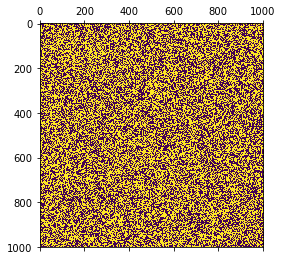

In [82]:
interact(show_population, results=fixed(historic_record), generations=(0, jumps, 1))

Debido a que `interact` computa la función que se le entrega cada vez que variamos un parámetro, hicimos que `next_generation` retornara una lista en lugar de una matriz de la generación que buscamos, para ahorrar una gran cantidad de tiempo de computación. El tradeoff de hacer esto es un aumento significativo en el uso de memoria RAM para poder almacenar la lista que contiene el resultado histórico de la población de células.

## 4.1. &nbsp;&nbsp;&nbsp; Decaimiento de la población en el tiempo

Como se pudo observar en el `interact` anterior, la población de células decae en el tiempo. Así que aprovecharemos las herramientas entregadas por `matplotlib` para ver qué tan rápido estas decaen:

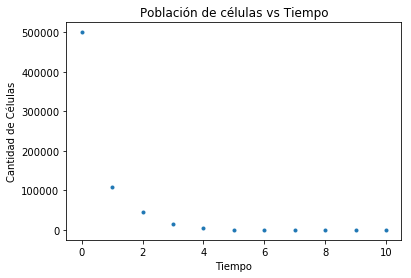

In [93]:
population = list()
for i in range(jumps + 1):
    population.append(np.sum(historic_record[i]))

populaton = np.asarray(population)
time = np.asarray(range(0, jumps + 1))
plt.plot(time, population, '.')
plt.title("Población de células vs Tiempo")
plt.ylabel("Cantidad de Células")
plt.xlabel("Tiempo")
plt.show()

De lo anterior, se puede observar que inicialmente comenzamos con 500000 células y a medida que va pasando el tiempo, la cantidad de estas tiende a decaer exponencialmente conforme pasa el tiempo.